In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import xarray as xr
import rasterio
from shapely.geometry import Polygon, LineString, Point
import netCDF4 as nc
import scipy as sp
import rioxarray as rio
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def meteo_interpolation(date,protipo,meteo_path='/media/toshiba-hdd/mlfires/dataset/images/meteo'):
    meteo_file = 'meteo_daily_'+date+'.nc'
    #print(meteo_path)
    #print(meteo_file)
    img_meteos = xr.open_dataset(os.path.join(meteo_path,meteo_file))
    img_meteos = img_meteos.drop([i for i in img_meteos.coords if i not in img_meteos.dims])
    img_meteos.attrs.clear()
    interp_img = img_meteos.interp(latitude=protipo["y"], longitude=protipo["x"],method='nearest')
    interp_img = interp_img.reindex(y=list(reversed(interp_img.y)))
    for var in interp_img.data_vars:
        interp_img[var] = interp_img[var].interpolate_na(dim='x', method='nearest',fill_value="extrapolate")
        interp_img[var] = interp_img[var].interpolate_na(dim='y', method='nearest',fill_value="extrapolate")
    interp_img = interp_img.drop(['latitude','longitude'])
    interp_img_masked = interp_img.where(protipo.fire1>0)#((protipo.ndvi.notnull()) & (protipo.ndvi!=0))
    interp_img_masked = interp_img_masked.squeeze()
    #interp_img_masked = interp_img_masked.drop('band')
    interp_img_masked = interp_img_masked.interp(y=protipo["y"], x=protipo["x"],method='nearest')
    #interp_img_masked = interp_img_masked.drop('time')
    #time = image.split('_')[0]
    interp_img_masked = interp_img_masked.assign_coords(time=pd.to_datetime(date).strftime('%Y-%m-%d'))
    #interp_img_masked = interp_img_masked.where(protipo['fire1'] != 0, np.nan)
    return interp_img_masked

In [3]:
def veg_interpolation(date,protipo,veg_path):
    img_veg = xr.open_dataset(veg_path)
    img_veg = img_veg.squeeze()
    #img_veg = img_veg.drop([i for i in img_veg.coords if i not in img_veg.dims])
    #img_meteos.attrs.clear()
    interp_img = img_veg.interp(y=protipo["y"], x=protipo["x"],method='nearest')
    #interp_img = interp_img.reindex(y=list(reversed(interp_img.y)))
    interp_img = interp_img.squeeze()
    #interp_img = interp_img.drop(['band','time'])
    try:
        interp_img = interp_img.drop('spatial_ref')
    except:
        i=1
    time = date
    interp_img = interp_img.assign_coords(time=pd.to_datetime(time).strftime('%Y-%m-%d'))
    #interp_img.to_netcdf(f'/media/toshiba-hdd/mlfires/dataset/images/veg_interp/{time}_veg_interp.nc')
    return interp_img

In [4]:
def lst_interpolation(date,protipo,lst_path):
#for image in c:
    img_lst = xr.open_dataset(lst_path)
    img_lst = img_lst.squeeze()
    #print(img_lst)
    #break
    interp_lst = img_lst.interp(y=protipo["y"], x=protipo["x"],method='nearest')
    interp_lst = interp_lst.reindex(y=list(reversed(interp_lst.y)))
    #print(interp_lst)
    #break
    for var in interp_lst.data_vars:
        interp_lst[var] = interp_lst[var].interpolate_na(dim='x', method='nearest',fill_value="extrapolate")
        interp_lst[var] = interp_lst[var].interpolate_na(dim='y', method='nearest',fill_value="extrapolate")
        #print(interp_lst)
       # break
    #break 
    interp_lst_masked = interp_lst.where(protipo.fire1>0)#((protipo.ndvi.notnull()))# & (protipo.ndvi!=0))
    #interp_lst_masked = interp_lst_masked.drop('band')
    time = date
    interp_lst_masked = interp_lst_masked.assign_coords(time=pd.to_datetime(time).strftime('%Y-%m-%d'))
    interp_lst_masked = interp_lst_masked.interp(y=protipo["y"], x=protipo["x"],method='nearest')
    interp_lst_masked = interp_lst_masked.squeeze()
    interp_lst_masked = interp_lst_masked.rename({'day':'lst_day','night':'lst_night'})
    interp_lst_masked['lst_day'] = interp_lst_masked['lst_day'].where(interp_lst_masked['lst_day'] != 0, np.nan)
    interp_lst_masked['lst_night'] = interp_lst_masked['lst_night'].where(interp_lst_masked['lst_night'] != 0, np.nan)
    #interp_lst_masked.to_netcdf(f'/media/toshiba-hdd/mlfires/dataset/images/lst_interp/{time}_lst_interp.nc')
    return interp_lst_masked

In [5]:
def find_nearest(date,mode = 'ndvi'):
    meteo_date = pd.to_datetime(date)
    if mode == 'ndvi':
        #print('Mode------ndvi')
        spath = '/media/toshiba-hdd/mlfires/dataset/images/ndvi'
    elif mode == 'lst':
        #print('Mode------lst')
        spath = '/media/toshiba-hdd/mlfires/dataset/images/lst'
    dict_files = {}
    list_of_files = os.listdir(spath)
    for file in list_of_files:
        start_date = pd.to_datetime(file.split('_')[0]).strftime('%Y-%m-%d')
        #print('ndvi start date:',start_date)
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
        end_date = start_date + timedelta(days=16)
        end_date = pd.to_datetime(end_date).strftime('%Y-%m-%d')
        end_date = end_date.replace('-',"")
        new_path = os.path.join(spath,file)
        dict_files[pd.to_datetime(end_date)]=new_path
        v_l_list = list(dict_files.keys())
    closest_date = None
    max_diff = timedelta(days=30)
    min_diff = max_diff
    for file_date in v_l_list:
        diff = meteo_date - file_date
        diff = timedelta(days=diff.days)
        #print(diff.days)
        if diff.days > 0 and diff < min_diff:
            closest_date = file_date
            min_diff = diff           
    #print(f"For date {date}, closest past date for {mode} is {closest_date}")
    try:
        im_path = dict_files[closest_date]
    except Exception as e:
        print(f"{date}: An error occurred while searching for {mode}: {e}")
    return(im_path)

In [6]:
def merge_dyn_stat(img_dyn,date,static_list):
    new_list = static_list.copy()
    var = date
    #print(variable)
    variable = datetime.strptime(var, "%Y%m%d")
    #weekday = variable.weekday()
    #print(weekday)
    #month = variable.month
    year = variable.year
   #print(month)
    #new_data = np.where(img_dyn['ndvi'].notnull(), weekday, np.nan)
    #data = np.where((img_dyn.ndvi.notnull()) & (protipo.ndvi!=0), month, np.nan)
    #img_dyn['weekday'] = xr.DataArray(new_data, dims=('y', 'x'))
    #img_dyn['month'] = xr.DataArray(data, dims=('y', 'x'))
    merged_static = xr.Dataset(coords=dict(
        y=(protipo.y.values),
        x=(protipo.x.values)))
    if year>2014:
        new_list.remove('POP_2011.nc') #also remove corine
        corine = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/static/corine2018/Corine_Level2.nc')
    else:       
        new_list.remove('POP_2018.nc') #also remove corine
        corine = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/static/corine2012/Corine_Level2.nc')
    for file in new_list:
        if file.endswith('nc') and file != 'static_merged.nc':
            xr_file = xr.open_dataset(f'/media/toshiba-hdd/mlfires/dataset/images/static/{file}')
            merged_static = xr.merge([merged_static,xr_file],compat='override')
    try:
        merged_static = merged_static.rename({'pop_11':'pop'})
    except:
        merged_static = merged_static.rename({'pop_18':'pop'})        
    #saved_merged_static = merged_static.to_netcdf(f'/media/toshiba-hdd/mlfires/dataset/images/dynamic/Merged_Dynamic_{var}.nc')
    merged_static = merged_static.rename({'roads':'road_dens'})
        #print(merged_static)
    final = xr.merge([img_dyn,merged_static,corine])
    return final
    #break

In [7]:
def concat_fires(date,protipo,final_no_fires):
    fires_path = '/media/toshiba-hdd/mlfires/dataset/images/fires'
    fires_list = os.listdir(fires_path)
    fire_file = [i for i in fires_list if str(date) in i]
    #print(fire_file)
    if fire_file:
        f = fire_file[0]
    else:
        f = 'protipo_firess.nc'
    fire = xr.open_dataset(os.path.join(fires_path,f))
    final_fire = xr.merge([final_no_fires,fire])
    final_fire['fire'] = final_fire.fire.where(protipo.fire1>0)#(protipo.ndvi.notnull()) & (protipo.ndvi!=0))
    return final_fire

In [12]:
def make_daily_file(list_of_dates):
#    protipo = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/final_dataset/20190925_dfsc.nc')
    protipo_for_lst = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/layers/protipo_lst.nc')
    #protipo_for_lst['fire1'] = protipo_for_lst.fire+1000
    protipo_for_lst['fire1'] = protipo_for_lst.lst_day.where(protipo_for_lst.lst_day>0,np.nan)
    static_list = os.listdir('/media/toshiba-hdd/mlfires/dataset/images/static')
    for date in list_of_dates:
        try:
            print(date)
            ndvi_file_path = find_nearest(date,mode = 'ndvi')
            lst_file_path = find_nearest(date,mode = 'lst')
            meteo_interp = meteo_interpolation(date, protipo_for_lst,meteo_path='/media/toshiba-hdd/mlfires/dataset/images/meteo')#kalw sinartish
            print('meteo time:',meteo_interp.time.values)
            ndvi_interp= veg_interpolation(date,protipo_for_lst,ndvi_file_path)
            print('ndvi time:',ndvi_interp.time.values)
            lst_interp = lst_interpolation(date,protipo_for_lst,lst_file_path)
            print('lst time:',lst_interp.time.values)
            dynamic = xr.merge([meteo_interp,ndvi_interp,lst_interp])
            print('merge done')
            #final = merge_dyn_stat(dynamic,date,static_list)
            final = dynamic.copy()
            if 'band' in list(final.data_vars):
                final = final.drop('band')
            final_with_fires = concat_fires(date,protipo_for_lst,final)
            final_with_fires['fire'] = final_with_fires.fire.fillna(0)
            final_with_fires = final_with_fires.where(protipo_for_lst.fire1.notnull())# & (protipo.ndvi!=0))
            final_with_fires = final_with_fires.astype('float32')
            variable = datetime.strptime(date, "%Y%m%d")
            weekday = variable.weekday()+1
            #print(weekday)
            month = variable.month
            year = variable.year
            # print(month)
            new_data = np.where(final_with_fires['ndvi'].notnull(), weekday, np.nan)
            data = np.where(final_with_fires['ndvi'].notnull(), month, np.nan)
            final_with_fires['weekday'] = xr.DataArray(new_data, dims=('y', 'x'))
            final_with_fires['month'] = xr.DataArray(data, dims=('y', 'x'))
            final_with_fires.to_netcdf('/media/toshiba-hdd/mlfires/dataset/images/final_dataset/'+date+'_df.nc')
        except Exception as e:
            print('Exception occured when trying to make file for date {} : {}'.format(date, e))

In [13]:
#meteo_daily_20200401.nc
#list_of_dates = [i.split('_')[0] for i in os.listdir('/media/toshiba-hdd/mlfires/dataset/images/meteo')]
list_of_dates = [i.split('.')[0].split('_')[-1] for i in os.listdir('/media/toshiba-hdd/mlfires/dataset/images/meteo') if i.startswith('meteo_daily') and '2021' in i]

In [16]:
#list_of_dates = ['20100625']
final_with_fires = make_daily_file(list_of_dates)

20210530
meteo time: 2021-05-30
ndvi time: 2021-05-30
lst time: 2021-05-30
merge done
20210522
meteo time: 2021-05-22
ndvi time: 2021-05-22
lst time: 2021-05-22
merge done
20210903
meteo time: 2021-09-03
ndvi time: 2021-09-03
lst time: 2021-09-03
merge done
20211012
meteo time: 2021-10-12
ndvi time: 2021-10-12
lst time: 2021-10-12
merge done
20210731
meteo time: 2021-07-31
ndvi time: 2021-07-31
lst time: 2021-07-31
merge done
20211001
meteo time: 2021-10-01
ndvi time: 2021-10-01
lst time: 2021-10-01
merge done
20211024
meteo time: 2021-10-24
ndvi time: 2021-10-24
lst time: 2021-10-24
merge done
20210626
meteo time: 2021-06-26
ndvi time: 2021-06-26
lst time: 2021-06-26
merge done
20210706
meteo time: 2021-07-06
ndvi time: 2021-07-06
lst time: 2021-07-06
merge done
20210708
meteo time: 2021-07-08
ndvi time: 2021-07-08
lst time: 2021-07-08
merge done
20210723
meteo time: 2021-07-23
ndvi time: 2021-07-23
lst time: 2021-07-23
merge done
20210612
meteo time: 2021-06-12
ndvi time: 2021-06-12


In [ ]:
final_with_fires['lst_day'] = final_with_fires['lst_day'].where(final_with_fires['lst_day'] != 0, np.nan)
final_with_fires['lst_night'] = final_with_fires['lst_night'].where(final_with_fires['lst_night'] != 0, np.nan)
final_with_fires['dem'] = final_with_fires['dem'].where(final_with_fires.dem>-10)
final_with_fires['pop'] = final_with_fires['pop'].where(final_with_fires.pop >= 0)
final_with_fires['curvature'] = final_with_fires['curvature'].where(final_with_fires.curvature>=0)

var = date
#print(variable)


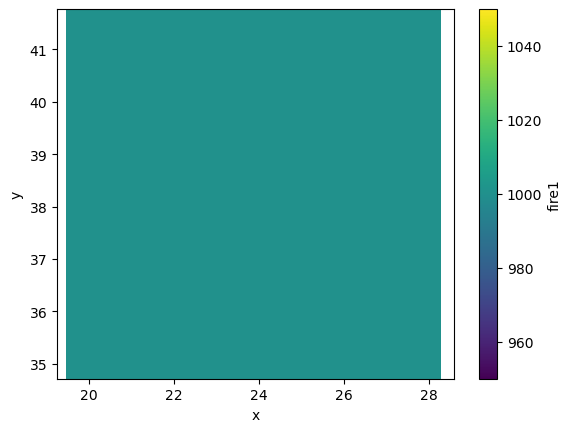

In [70]:
protipo_for_lst = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/layers/protipo_firess.nc')
protipo_for_lst['fire1'] = protipo_for_lst.fire+1000
protipo_for_lst['fire1'] = protipo_for_lst.fire1.where(protipo_for_lst.fire1>0,np.nan)
protipo_for_lst['fire'].plot()

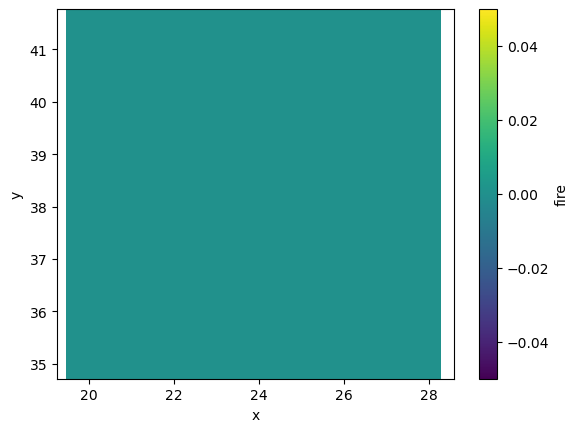

In [75]:
protipo_for_lst['fire'].plot()

## Final dataset corrections

In [8]:
for i,file in enumerate(os.listdir(path)):
    if file.startswith('.'):
        print(i,file)

955 .ipynb_checkpoints


In [9]:
path = '/media/toshiba-hdd/mlfires/dataset/images/final_dataset'
for file in os.listdir(path)[956:]:
#    try:
    with xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/final_dataset/20190916_dfsc.nc') as ds:
        final_with_fires = ds.load()
    print(file)
    var = file.split("_")[0]
    #print(variable)
    date = datetime.strptime(var, "%Y%m%d")
    final_with_fires['lst_night'] = final_with_fires['lst_day'].where(final_with_fires['lst_day'] != 0, np.nan)
    final_with_fires['lst_night'] = final_with_fires['lst_night'].where(final_with_fires['lst_night'] != 0, np.nan)
    final_with_fires['dem'] = final_with_fires['dem'].where(final_with_fires.dem>-10)
    final_with_fires['pop'] = final_with_fires['pop'].where(final_with_fires.pop >= 0)
    final_with_fires['curvature'] = final_with_fires['curvature'].where(final_with_fires.curvature>=0)
    weekday = date.weekday()+1
    #print(weekday)
    month = date.month
    year = date.year
   # print(month)
    new_data = np.where(final_with_fires['ndvi'].notnull(), weekday, np.nan)
    data = np.where(final_with_fires['ndvi'].notnull(), month, np.nan)
    final_with_fires['weekday'] = xr.DataArray(new_data, dims=('y', 'x'))
    final_with_fires['month'] = xr.DataArray(data, dims=('y', 'x'))
    final_with_fires = final_with_fires.astype('float32')
    final_with_fires.to_netcdf(os.path.join(path,file))
 #   except:
 #       print('Error in file: ', file)

20170814_dfsc_.nc
20190603_dfsc.nc
20141015_dfsc.nc
20160525_dfsc.nc
20130611_dfsc.nc
20100719_dfsc.nc
20100401_dfsc.nc
20181023_dfsc.nc
20160325_dfsc.nc
20170412_dfsc.nc
20120411_dfsc.nc
20140428_dfsc.nc
20141018_dfsc_.nc
20170528_dfsc.nc
20170831_dfsc.nc
20160706_dfsc_.nc
20190702_dfsc.nc
20180910_dfsc.nc
20150821_dfsc_.nc
20180628_dfsc.nc
20160909_dfsc.nc
20140921_dfsc_.nc
20100724_dfsc_.nc
20150326_dfsc.nc
20160427_dfsc.nc
20180903_dfsc.nc
20180503_dfsc.nc
20100906_dfsc.nc
20170806_dfsc_.nc
20141013_dfsc.nc
20110601_dfsc.nc
20170429_dfsc.nc
20140823_dfsc_.nc
20120806_dfsc.nc
20180906_dfsc.nc
20170730_dfsc_.nc
20101028_dfsc.nc
20110909_dfsc_.nc
20100429_dfsc.nc
20110728_dfsc.nc
20140929_dfsc_.nc
20100915_dfsc.nc
20160727_dfsc.nc
20140408_dfsc.nc
20100613_dfsc.nc
20150910_dfsc.nc
20150728_dfsc.nc
20160823_dfsc_.nc
20100716_dfsc.nc
20150514_dfsc.nc
20131015_dfsc.nc
20100927_dfsc.nc
20100403_dfsc.nc
20110926_dfsc_.nc
20120727_dfsc_.nc
20120719_dfsc_.nc
20100811_dfsc_.nc
20140901_dfsc.n

In [ ]:
path = '/media/toshiba-hdd/mlfires/dataset/images/final_dataset'
for file in os.listdir(path):
    try:
        

In [10]:
test = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/final_dataset/20190812_dfsc_.nc')

In [16]:
date = '20190812'

In [27]:
protipo_for_lst = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/layers/protipo_firess.nc')
protipo_for_lst['fire1'] = protipo_for_lst.fire+1000
lst_file_path = find_nearest(date,mode = 'lst')
lst_interp = lst_interpolation(date,protipo_for_lst,lst_file_path)
test['lst_day'] = lst_interp['lst_day']
test['lst_night'] = lst_interp['lst_night']

For date 20190812, closest past date for lst is 2019-08-05 00:00:00


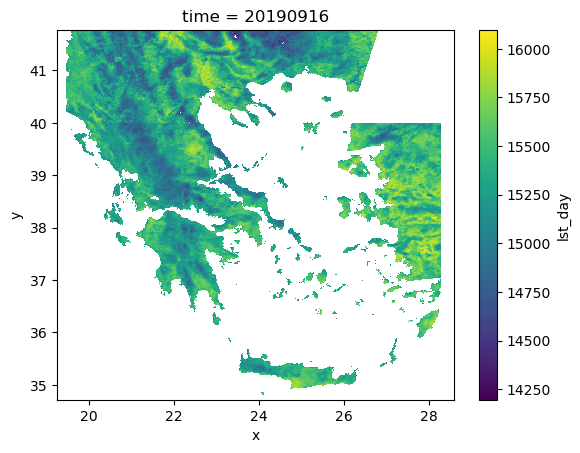

In [28]:
test.lst_day.plot()

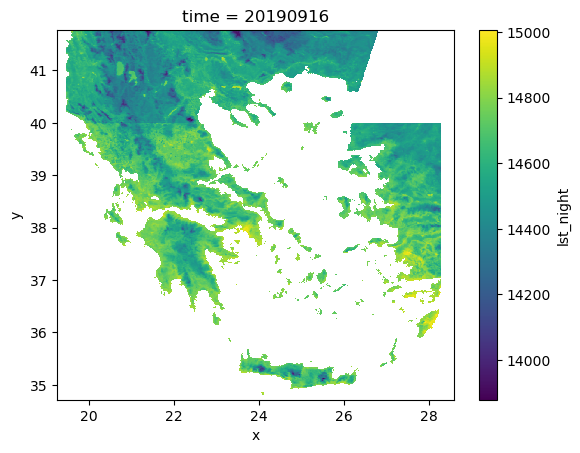

In [29]:
test.lst_night.plot()

In [48]:
coords = [final_with_fires.coords[dim] for dim in final_with_fires.dims]

In [114]:
results_raw = {'dom_dir': {'max': 8,'min': 0,'mean': 1.4499633297492498,'std': 2.425195911019028},
 'dom_vel': {'max': 20.72919,'min': 0.15180318,'mean': 3.1542678,'std': 1.9442333},
 'res_max': {'max': 20.72919,'min': 0.3611715,'mean': 3.3772633,'std': 1.9066138},
 'dir_max': {'max': 8.0,'min': 1.0,'mean': 4.311743145297046,'std': 2.500581436120126},
 'max_dew_temp': {'max': 300.55347,'min': 250.38052,'mean': 286.00635,'std': 5.2556643},
 'min_dew_temp': {'max': 297.85083,'min': 249.37547,'mean': 281.42838,'std': 5.5293293},
 'mean_dew_temp': {'max': 299.11478,'min': 250.38052,'mean': 283.68484,'std': 5.297758},
 'max_temp': {'max': 318.1582,'min': 253.31717,'mean': 295.4787,'std': 7.195512},
 'min_temp': {'max': 303.72144,'min': 252.43391,'mean': 286.04654,'std': 6.4882855},
 'mean_temp': {'max': 310.36667,'min': 253.31717,'mean': 290.88797,'std': 6.6792784},
 'rain_7_days': {'max': 0.2980887,'min': 0.0,'mean': 0.005029369,'std': 0.013408612},
  'ndvi':{'max': 10000,'min': -2000,'mean': 2032.5,'std': 2840},
  'evi':{'max': 10000,'min': -2000,'mean':1225,'std': 1761},     
  'lst_day': {'max': 17139.0,'min': 12496.0,'mean': 15016.50150293233,'std': 395.7591248309982},
 'lst_night': {'max': 16123.0,'min': 11773.0,'mean': 14319.586605723114,'std': 305.89877286784696},
 'pop': {'max': 2850478.5, 'min': 0.0, 'mean': 38727.31, 'std': 141118.22},
 'slope': {'max': 250.0, 'min': 69.0, 'mean': 241.8354, 'std': 11.278141},
 'road_dens': {'max': 1346.8986,'min': 0.0,'mean': 85.15466,'std': 127.47959},
 'dem': {'max': 2882.9453,'min': -7.000079,'mean': 522.5567,'std': 445.71954},
 'curvature': {'max': 0.73661584,'mean': 0.051498357,'min': 0.0,'std': 0.05853522},
 'aspect': {'max': 255.0, 'min': 0.0, 'mean': 126.018456, 'std': 73.28073},
 'f81': {'max': 1.0, 'min': 0.0, 'mean': 0.06872847, 'std': 0.14350714},
 'frequency': {'max': 1.0, 'min': 0.0, 'mean': 0.013226982, 'std': 0.06772623}}

In [115]:
results_ref = {'dom_vel': {'max': 21,'min': 0, 'mean': 3.1542678,'std': 1.9442333},
 'res_max': {'max': 21,'min': 0,'mean': 3.3772633,'std': 1.9066138},
 'max_dew_temp': {'max': 301,'min': 250,'mean': 286.00635,'std': 5.2556643},
 'min_dew_temp': {'max': 298,'min': 249,'mean': 281.42838,'std': 5.5293293},
 'mean_dew_temp': {'max': 300,'min': 250,'mean': 283.68484,'std': 5.297758},
 'max_temp': {'max': 319,'min': 253,'mean': 295.4787,'std': 7.195512},
 'min_temp': {'max': 304,'min': 252,'mean': 286.04654,'std': 6.4882855},
 'mean_temp': {'max': 311,'min': 253,'mean': 290.88797,'std': 6.6792784},
 'rain_7_days': {'max': 0.3,'min': 0.0,'mean': 0.005029369,'std': 0.013408612},
 'ndvi':{'max': 10000,'min': -2000,'mean': 2032.5,'std': 2840},
 'evi':{'max': 10000,'min': -2000,'mean':1225,'std': 1761},     
 'lst_day': {'max': 20000,'min': 7500,'mean': 5555.841656055125,'std': 7253.955932725438},
 'lst_night': {'max': 19000,'min': 7500,'mean': 5325.288676373827,'std': 6921.655261918272},
 'pop': {'max': 2850478.5, 'min': 0.0, 'mean': 38727.31, 'std': 141118.22},
 'slope': {'max': 250.0, 'min': 69.0, 'mean': 241.8354, 'std': 11.278141},
 'road_dens': {'max': 1346.8986,'min': 0.0,'mean': 85.15466,'std': 127.47959},
 'dem': {'max': 2882.9453,'min': -7.000079,'mean': 522.5567,'std': 445.71954},
 'curvature': {'max': 0.73661584,'mean': 0.051498357,'min': 0.0,'std': 0.05853522},
 'aspect': {'max': 255.0, 'min': 0.0, 'mean': 126.018456, 'std': 73.28073},
 'f81': {'max': 1.0, 'min': 0.0, 'mean': 0.06872847, 'std': 0.14350714},
 'frequency': {'max': 1.0, 'min': 0.0, 'mean': 0.013226982, 'std': 0.06772623}
 }

In [116]:
import json 
      
# Serializing json  
with open("/media/toshiba-hdd/mlfires/dataset/images/norm_values_raw.json", "w") as outfile:
    json.dump(results_raw, outfile)

In [117]:
with open("/media/toshiba-hdd/mlfires/dataset/images/norm_values_ref.json", "w") as outfile:
    json.dump(results_ref, outfile)

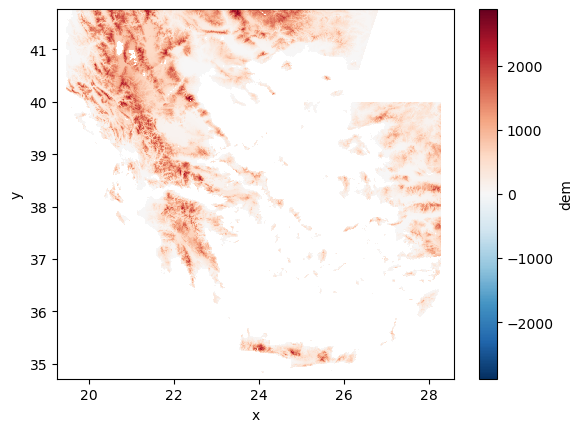

In [119]:
final_with_fires.dem.plot()

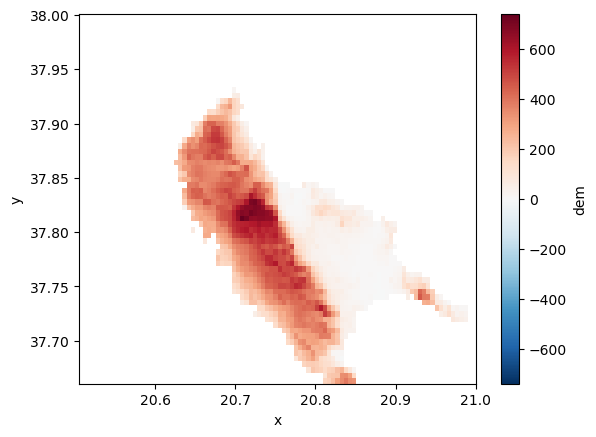

In [118]:
final_with_fires.dem.sel(y=slice(38,37.663090),x=slice(20.506817,21)).plot()

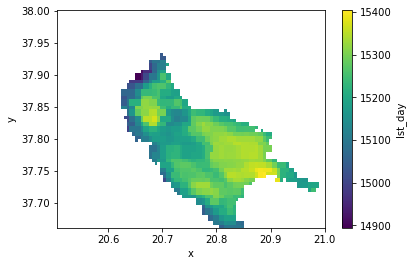

In [19]:
#final_with_fires.lst_day.plot()
xr.where(final_with_fires.lst_day==0,np.mean(final_with_fires.lst_day.values),final_with_fires.lst_day).sel(y=slice(38,37.663090),x=slice(20.506817,21)).plot()

In [121]:
dem = xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/final_dataset/20190926_dfsc.nc')

In [127]:
dem['dem1'] = final_with_fires['dem'].where(final_with_fires.dem>-1000)

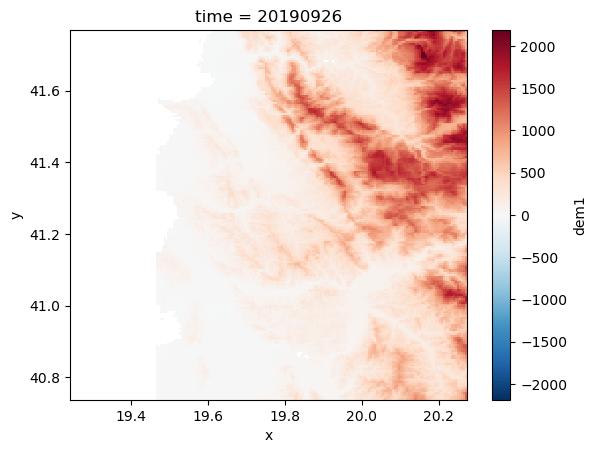

In [128]:
dem.dem1[0:200,0:200].plot()

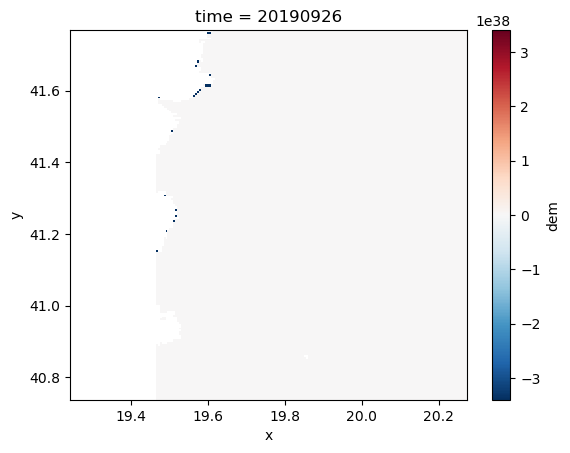

In [124]:
dem.dem[0:200,0:200].plot()

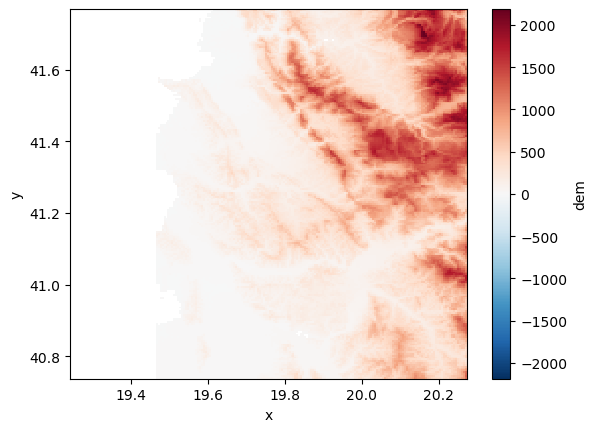

In [126]:
final_with_fires.dem[0:200,0:200].plot()

In [129]:
dem.dem1.min()

<xarray.DataArray 'dem1' ()>
array(-7.00007915)
Coordinates:
    time     object ...

In [30]:
xr.open_dataset('/media/toshiba-hdd/mlfires/dataset/images/ndvi/20191008_veg.nc').time.values

numpy.datetime64('2019-10-08T00:00:00.000000000')